In [4]:
import pandas as pd

# Load training data
train_data = pd.read_csv(r'C:\Users\dundr\Downloads\CMAPSSData\train_FD001.txt', delim_whitespace=True, header=None)

# Load test data
test_data = pd.read_csv(r'C:\Users\dundr\Downloads\CMAPSSData\test_FD001.txt', delim_whitespace=True, header=None)

# Load RUL (Remaining Useful Life) values for test data
rul_data = pd.read_csv(r'C:\Users\dundr\Downloads\CMAPSSData\RUL_FD001.txt', delim_whitespace=True, header=None)


In [5]:
print(train_data.head())
print(train_data.describe())
print(train_data.info())

   0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...      16       17       18      19    20   21    22     23     24  \
0  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

        25  
0  23.4190  
1  23.4236  
2  23.3442  
3  23.3739  
4  23.4044  

[5 rows

In [6]:
columns = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_measurement_{i}' for i in range(1, 22)]

train_data.columns = columns
test_data.columns = columns
rul_data.columns = ['RUL']


In [7]:
# Example: Select data for the first 10 engines
subset_train_data = train_data[train_data['unit_number'].isin(range(1, 11))]
subset_test_data = test_data[test_data['unit_number'].isin(range(1, 11))]

# Save the subset
subset_train_data.to_csv('FD001_train_subset.csv', index=False)
subset_test_data.to_csv('FD001_test_subset.csv', index=False)


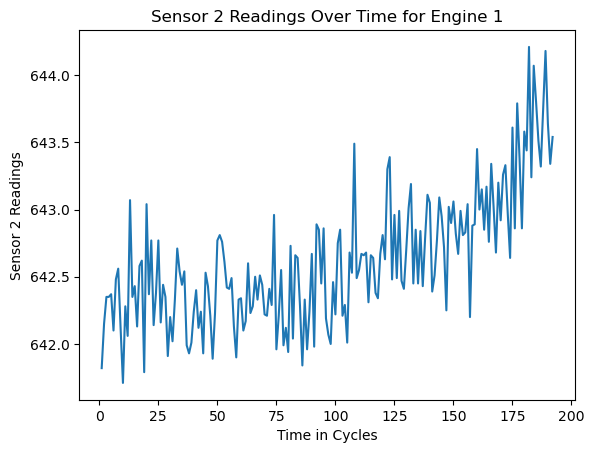

In [8]:
import matplotlib.pyplot as plt

# Plot sensor 2 readings over time for engine 1
engine_1_data = subset_train_data[subset_train_data['unit_number'] == 1]
plt.plot(engine_1_data['time_in_cycles'], engine_1_data['sensor_measurement_2'])
plt.xlabel('Time in Cycles')
plt.ylabel('Sensor 2 Readings')
plt.title('Sensor 2 Readings Over Time for Engine 1')
plt.show()


In [26]:
# Correlation matrix
corr_matrix = subset_train_data.corr()

# Sort correlations with time_in_cycles (as a proxy for RUL)
sensor_corr_with_time = corr_matrix['time_in_cycles'].sort_values(ascending=False)
print(sensor_corr_with_time)


time_in_cycles           1.000000
sensor_2_ma              0.656155
sensor_measurement_11    0.647304
sensor_measurement_4     0.643467
sensor_measurement_15    0.596942
sensor_measurement_17    0.585302
sensor_measurement_2     0.572213
sensor_measurement_3     0.561541
sensor_measurement_9     0.498742
sensor_measurement_14    0.442981
sensor_measurement_8     0.416374
sensor_measurement_13    0.405319
sensor_measurement_6     0.132633
sensor_2_diff            0.014645
op_setting_1             0.005322
op_setting_2            -0.015395
unit_number             -0.056749
sensor_measurement_7    -0.579889
sensor_measurement_20   -0.601820
sensor_measurement_21   -0.602352
sensor_measurement_12   -0.609982
op_setting_3                  NaN
sensor_measurement_1          NaN
sensor_measurement_5          NaN
sensor_measurement_10         NaN
sensor_measurement_16         NaN
sensor_measurement_18         NaN
sensor_measurement_19         NaN
Name: time_in_cycles, dtype: float64


In [27]:
# Example: Calculate moving average of a sensor reading over the last 5 cycles
subset_train_data['sensor_2_ma'] = subset_train_data.groupby('unit_number')['sensor_measurement_2'].rolling(window=5).mean().reset_index(0, drop=True)

# Example: Difference between consecutive cycles for a sensor reading
subset_train_data['sensor_2_diff'] = subset_train_data.groupby('unit_number')['sensor_measurement_2'].diff()


C:\Users\dundr\AppData\Local\Temp\ipykernel_18156\2951485916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train_data['sensor_2_ma'] = subset_train_data.groupby('unit_number')['sensor_measurement_2'].rolling(window=5).mean().reset_index(0, drop=True)
C:\Users\dundr\AppData\Local\Temp\ipykernel_18156\2951485916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_train_data['sensor_2_diff'] = subset_train_data.groupby('unit_number')['sensor_measurement_2'].diff()


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features (exclude 'unit_number' and 'time_in_cycles')
X = subset_train_data.drop(['unit_number', 'time_in_cycles'], axis=1)

# Target (use 'time_in_cycles' as a proxy for RUL)
y = subset_train_data['time_in_cycles']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [36]:
import numpy as np

# Check for NaNs in X_train and y_train
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())

# Check for infinite values in X_train and y_train
print("Infinities in X_train:", np.isinf(X_train).sum())
print("Infinities in y_train:", np.isinf(y_train).sum())


NaNs in X_train: 0
NaNs in y_train: 0
Infinities in X_train: 0
Infinities in y_train: 0


In [37]:
# Check for extremely large values
print("Max value in X_train:", np.max(X_train))
print("Max value in y_train:", np.max(y_train))


Max value in X_train: 6.224049735729869
Max value in y_train: 286


In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)  # Don't forget to scale the validation data too


In [40]:
import numpy as np

# Ensure y_train is aligned with X_train
y_train = y_train[:len(X_train)]

print(f"New Shape of X_train: {X_train.shape}")
print(f"New Length of y_train: {len(y_train)}")


New Shape of X_train: (1674, 26)
New Length of y_train: 1674


In [42]:
# Ensure that y_train only contains rows corresponding to X_train
X_train_clean = X_train[~np.isnan(X_train).any(axis=1) & ~np.isinf(X_train).any(axis=1)]
y_train_clean = y_train[:len(X_train_clean)]

print(f"Aligned Shape of X_train: {X_train_clean.shape}")
print(f"Aligned Length of y_train: {len(y_train_clean)}")


Aligned Shape of X_train: (1674, 26)
Aligned Length of y_train: 1674


In [43]:
# Train the model after aligning the data
model = LinearRegression()
model.fit(X_train_clean, y_train_clean)


LinearRegression()

In [45]:
# Train the model after aligning the data
model = LinearRegression()
model.fit(X_train_clean, y_train_clean)

# The model has been trained, no need to train it again


LinearRegression()

In [47]:
import numpy as np

# Check for NaNs in X_val
print("NaNs in X_val:", np.isnan(X_val).sum())

# Check for infinite values in X_val
print("Infinities in X_val:", np.isinf(X_val).sum())


NaNs in X_val: 7
Infinities in X_val: 0


In [48]:
# Remove rows with NaNs or infinite values
X_val_clean = X_val[~np.isnan(X_val).any(axis=1)]
X_val_clean = X_val_clean[~np.isinf(X_val_clean).any(axis=1)]

# Ensure that y_val is aligned with the cleaned X_val
y_val_clean = y_val[:len(X_val_clean)]


In [49]:
# Predict and evaluate the model with cleaned X_val
y_pred = model.predict(X_val_clean)
mse = mean_squared_error(y_val_clean, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 4807.7332233347715


In [50]:
from sklearn.metrics import mean_absolute_error, r2_score

# Mean Absolute Error
mae = mean_absolute_error(y_val_clean, y_pred)
print(f'Mean Absolute Error: {mae}')

# R-squared
r2 = r2_score(y_val_clean, y_pred)
print(f'R-squared: {r2}')


Mean Absolute Error: 57.70890390158063
R-squared: -0.0191796951878227


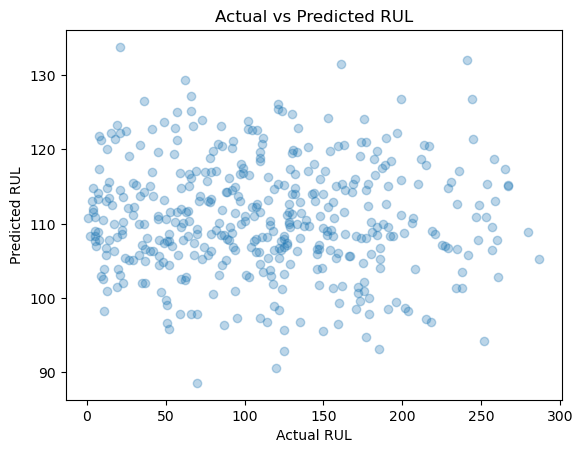

In [51]:
import matplotlib.pyplot as plt

plt.scatter(y_val_clean, y_pred, alpha=0.3)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.show()


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_clean, y_train_clean)

# Predict and evaluate the Random Forest model
rf_y_pred = rf_model.predict(X_val_clean)
rf_mse = mean_squared_error(y_val_clean, rf_y_pred)
print(f'Random Forest Mean Squared Error: {rf_mse}')


Random Forest Mean Squared Error: 4829.607873222749


In [55]:
!pip install xgboost
from xgboost import XGBRegressor

# Train an XGBoost model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_clean, y_train_clean)

# Predict and evaluate the XGBoost model
xgb_y_pred = xgb_model.predict(X_val_clean)
xgb_mse = mean_squared_error(y_val_clean, xgb_y_pred)
print(f'XGBoost Mean Squared Error: {xgb_mse}')


XGBoost Mean Squared Error: 5739.948644205917


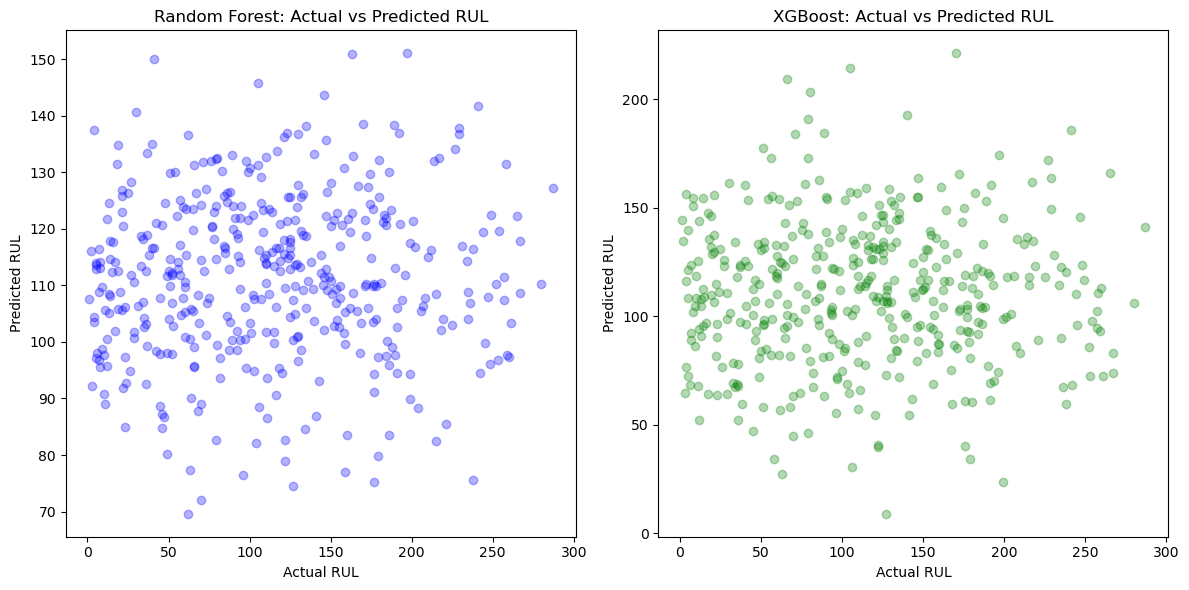

In [56]:
import matplotlib.pyplot as plt

# Plot actual vs predicted for Random Forest
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_val_clean, rf_y_pred, alpha=0.3, color='blue')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Random Forest: Actual vs Predicted RUL')

# Plot actual vs predicted for XGBoost
plt.subplot(1, 2, 2)
plt.scatter(y_val_clean, xgb_y_pred, alpha=0.3, color='green')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('XGBoost: Actual vs Predicted RUL')

plt.tight_layout()
plt.show()


In [57]:
from sklearn.model_selection import GridSearchCV

# Example: Grid search for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_clean, y_train_clean)

print(f'Best Parameters: {grid_search.best_params_}')


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [64]:
# Manually define feature names based on the columns you used
feature_names = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + \
                [f'sensor_measurement_{i}' for i in range(1, 22)]


In [66]:
print(f"Length of importances: {len(importances)}")
print(f"Length of feature_names: {len(feature_names)}")


Length of importances: 26
Length of feature_names: 24


In [67]:
feature_names = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + \
                [f'sensor_measurement_{i}' for i in range(1, X_train_clean.shape[1] - 2 + 1)]


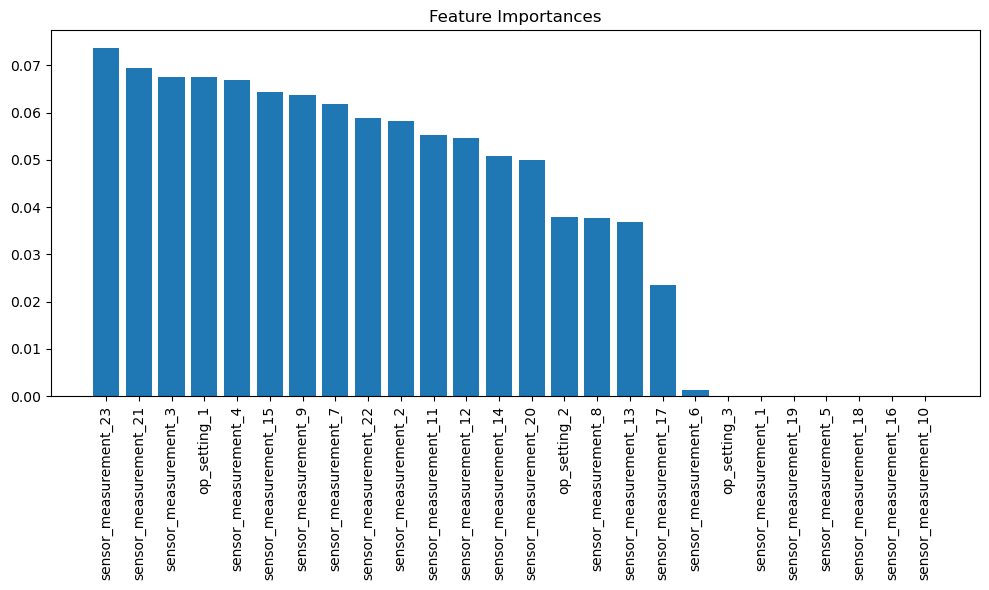

In [68]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.tight_layout()
plt.show()


In [73]:
import joblib

# Save the model
joblib.dump(rf_model, 'rf_model.pkl')

# Git Commands
# Initialize Git repository, add, commit, and push your files to GitHub
# Run these commands in your terminal
'''
git init
git add .
git commit -m "Initial commit"
git branch -M main
git remote add origin https://github.com/your_username/your_repository_name.git
git push -u origin main
'''


'\ngit init\ngit add .\ngit commit -m "Initial commit"\ngit branch -M main\ngit remote add origin https://github.com/your_username/your_repository_name.git\ngit push -u origin main\n'

In [74]:
import joblib

# Save the Random Forest model
joblib.dump(rf_model, 'rf_model.pkl')

# Save the XGBoost model (if you want to keep both)
joblib.dump(xgb_model, 'xgb_model.pkl')


['xgb_model.pkl']